<a href="https://colab.research.google.com/github/ziatdinovmax/pyroVED/blob/main/examples/rVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#*r*-VAE: Application to arbitrary rotated 2D images

Prepared by Maxim Ziatdinov

E-mail: ziatdinovmax@gmail.com

In [1]:
#@title Installation
!pip install -q pyroved kornia

In [2]:
#@title Imports
from typing import Tuple

import pyroved as pv
import torch
import kornia as K
from torchvision import datasets
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#@title Helper functions
def rotate_images(imgdata, rotation_range: Tuple[int]) -> Tuple[torch.Tensor]:
    torch.manual_seed(0)
    theta = torch.randint(*rotation_range, size=(len(imgdata),))
    imgdata = K.rotate(imgdata.float()[:, None], theta.float())
    imgdata = imgdata / imgdata.max()
    return imgdata, theta


def get_mnist_data(rotation_range: Tuple[int]) -> Tuple[torch.Tensor]:
    !wget -qq www.di.ens.fr/~lelarge/MNIST.tar.gz
    !tar -zxf MNIST.tar.gz
    mnist_trainset = datasets.MNIST(
        root='.', train=True, download=False, transform=None)
    images_r, theta = rotate_images(mnist_trainset.data, rotation_range)
    return images_r, pv.utils.to_onehot(mnist_trainset.targets, 10), theta

Get training data and create a dataloader object:

In [ ]:
train_data, train_labels, angles = get_mnist_data(rotation_range=[-60, 61])
train_loader = pv.utils.init_dataloader(train_data, batch_size=200)

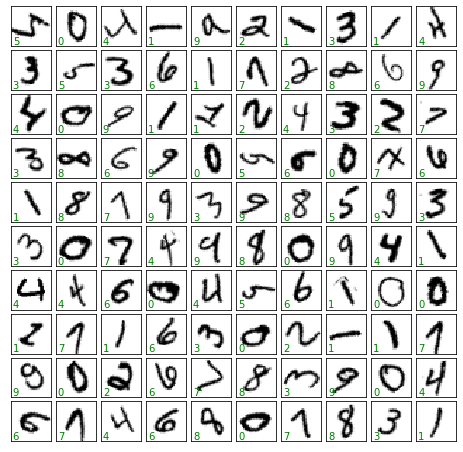

In [5]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, im, lbl in zip(axes.flat, train_data, train_labels):
    ax.imshow(im.squeeze(), cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(lbl.argmax().item()),
            transform=ax.transAxes, color='green')

First, we explore the simple VAE:

In [6]:
in_dim = (28, 28)

# Initialize probabilistic VAE model ->
# (coord=0: vanilla VAE
#  coord=1: rotations only
#  coord=2: translations only
#  coord=3: rotations+translations)
vae = pv.models.trVAE(in_dim, latent_dim=2, coord=0, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)
# Train for n epochs:
for e in range(100):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 224.8867
Epoch: 2 Training loss: 192.3686
Epoch: 3 Training loss: 186.2782
Epoch: 4 Training loss: 182.7144
Epoch: 5 Training loss: 180.4599
Epoch: 6 Training loss: 178.7519
Epoch: 7 Training loss: 177.2982
Epoch: 8 Training loss: 175.9263
Epoch: 9 Training loss: 174.8882
Epoch: 10 Training loss: 173.9411
Epoch: 11 Training loss: 173.0587
Epoch: 12 Training loss: 172.3400
Epoch: 13 Training loss: 171.7512
Epoch: 14 Training loss: 171.1462
Epoch: 15 Training loss: 170.5749
Epoch: 16 Training loss: 170.1535
Epoch: 17 Training loss: 169.7181
Epoch: 18 Training loss: 169.3463
Epoch: 19 Training loss: 168.9543
Epoch: 20 Training loss: 168.6385
Epoch: 21 Training loss: 168.3122
Epoch: 22 Training loss: 167.9966
Epoch: 23 Training loss: 167.8294
Epoch: 24 Training loss: 167.5184
Epoch: 25 Training loss: 167.2499
Epoch: 26 Training loss: 167.1015
Epoch: 27 Training loss: 166.9261
Epoch: 28 Training loss: 166.6126
Epoch: 29 Training loss: 166.4274
Epoch: 30 Training loss

Visualize the learned latent manifold:

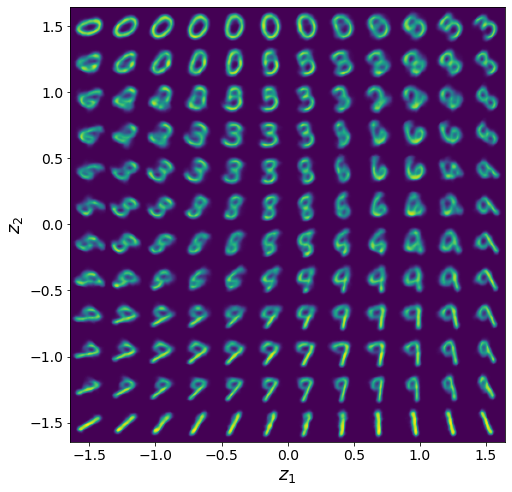

In [7]:
vae.manifold2d(d=12, cmap='viridis');

Encode all the data and view the encoded values as a scatter plot:

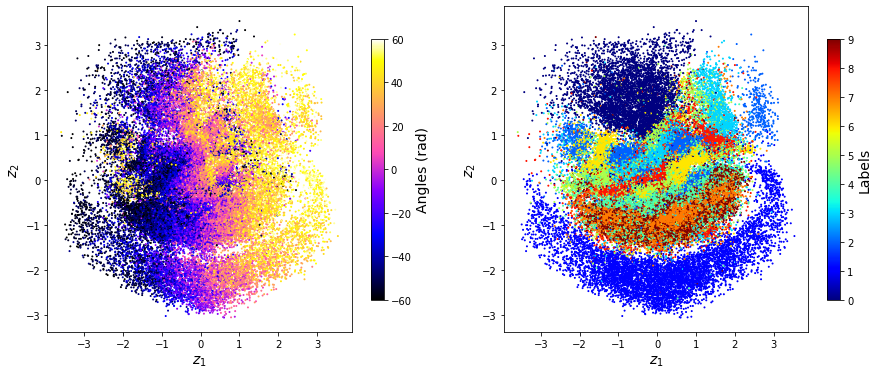

In [8]:
z_mean, z_sd = vae.encode(train_data)
_, labels = torch.max(train_labels, 1)
labels = labels.cpu().tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,-1], z_mean[:,-2], c=angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,-1], z_mean[:,-2], c=labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);

The examination of latent space shows that the angle changes along the first latent direction, whereas the digit changes mostly along the second latent dimension. This clearly illustrates the disentanglement of the data representation concept, where the rotational angle and class emerge as the two most prominent factors of variation within the data.

Now let's train VAE with rotational invariance (aka rVAE):

In [9]:
# Reinitialize dataloader
train_loader = pv.utils.init_dataloader(train_data, batch_size=200)

In [10]:
in_dim = (28, 28)

# Initialize probabilistic VAE model ->
# (coord=0: vanilla VAE
#  coord=1: rotations only
#  coord=2: translations only
#  coord=3: rotations+translations)
rvae = pv.models.trVAE(in_dim, latent_dim=2, coord=1, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(rvae)
# Train for n epochs:
for e in range(100):
    trainer.step(train_loader, scale_factor=3)
    trainer.print_statistics()

Epoch: 1 Training loss: 250.5616
Epoch: 2 Training loss: 206.4765
Epoch: 3 Training loss: 197.0023
Epoch: 4 Training loss: 191.6669
Epoch: 5 Training loss: 187.2047
Epoch: 6 Training loss: 184.0478
Epoch: 7 Training loss: 182.0111
Epoch: 8 Training loss: 180.3159
Epoch: 9 Training loss: 178.9715
Epoch: 10 Training loss: 178.0622
Epoch: 11 Training loss: 177.2772
Epoch: 12 Training loss: 176.4970
Epoch: 13 Training loss: 176.0549
Epoch: 14 Training loss: 175.3369
Epoch: 15 Training loss: 174.7044
Epoch: 16 Training loss: 174.3017
Epoch: 17 Training loss: 173.8871
Epoch: 18 Training loss: 173.3014
Epoch: 19 Training loss: 173.0822
Epoch: 20 Training loss: 172.6847
Epoch: 21 Training loss: 172.3612
Epoch: 22 Training loss: 172.0020
Epoch: 23 Training loss: 171.6393
Epoch: 24 Training loss: 171.4202
Epoch: 25 Training loss: 171.0164
Epoch: 26 Training loss: 170.8633
Epoch: 27 Training loss: 170.4082
Epoch: 28 Training loss: 170.1794
Epoch: 29 Training loss: 170.0253
Epoch: 30 Training loss

Visualize the learned latent manifold:

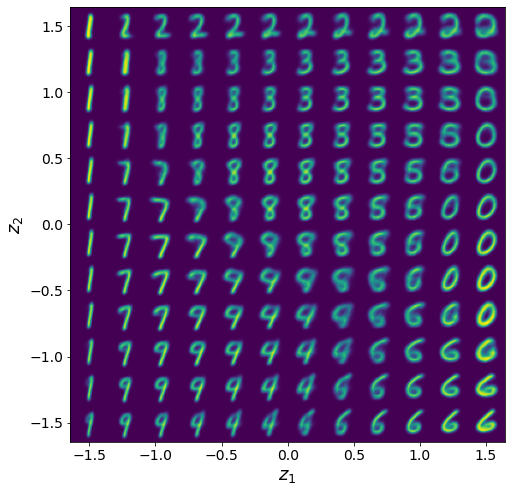

In [11]:
rvae.manifold2d(d=12, cmap='viridis');

Encode all the data and view the encoded values as a scatter plot:

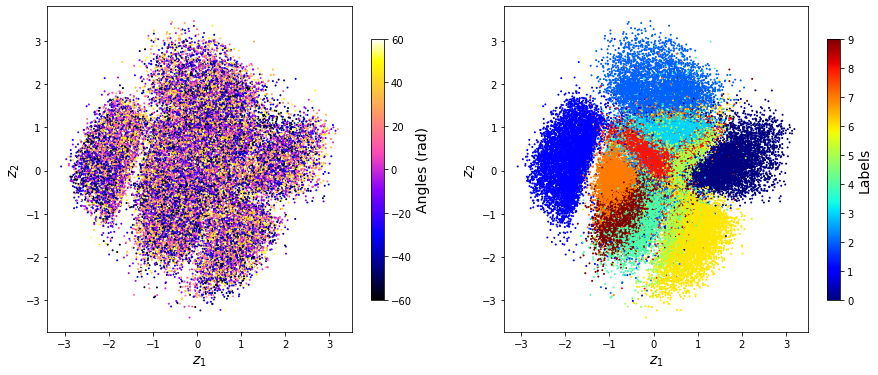

In [12]:
z_mean, z_sd = rvae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,-1], z_mean[:,-2], c=angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,-1], z_mean[:,-2], c=labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);

In this case, the digits in the latent space are oriented in one direction. The latent space shows that the angles are now random, whereas the digits form well-defined clusters (rather remarkable given that we encode the data set using only two latent variables). We also get the angle as one of the latent variables, and the latent angle and ground truth angle are compared in the figure above. Note that they are linearly related, but at the same time latent angles have broad distribution. This is unsurprising since an angle is one of the characteristics of handwriting style and varies from person to person! The latent representation we discovered hence compensated by this fact via introducing it as an additional augmentation variable, and then separating it from other factors of variation.


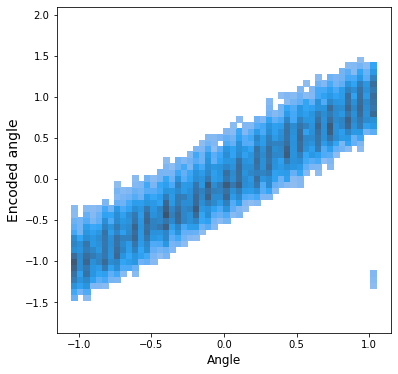

In [13]:
plt.figure(figsize=(6, 6))
plt.xlabel("Angle", fontsize=12)
plt.ylabel("Encoded angle", fontsize=14)
ax = sns.histplot(x=torch.deg2rad(angles.float()), y=z_mean[:, 0], bins=50, pthresh=.1);

Finally, we illustrate the class-conditioned rVAE (crVAE) applied to this data set. Note that the only two things we have to do is add labels to our data loader and specify number of classes when initializing the crVAE model - pyroVED will take care of the rest.

In [14]:
# Initialize dataloader (here we are adding labels to the training data)
train_loader = pv.utils.init_dataloader(train_data, train_labels, batch_size=200)

In [15]:
in_dim = (28, 28)

# Initialize probabilistic VAE model ->
# (coord=0: vanilla VAE
#  coord=1: rotations only
#  coord=2: translations only
#  coord=3: rotations+translations)
crvae = pv.models.trVAE(in_dim, latent_dim=2, num_classes=10, coord=1, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(crvae)
# Train for n epochs:
for e in range(100):
    trainer.step(train_loader, scale_factor=3)
    trainer.print_statistics()

Epoch: 1 Training loss: 242.3101
Epoch: 2 Training loss: 192.3947
Epoch: 3 Training loss: 180.5050
Epoch: 4 Training loss: 174.6526
Epoch: 5 Training loss: 171.1777
Epoch: 6 Training loss: 169.2620
Epoch: 7 Training loss: 166.6892
Epoch: 8 Training loss: 164.8139
Epoch: 9 Training loss: 163.5983
Epoch: 10 Training loss: 162.9162
Epoch: 11 Training loss: 162.1721
Epoch: 12 Training loss: 161.3899
Epoch: 13 Training loss: 160.9357
Epoch: 14 Training loss: 160.4601
Epoch: 15 Training loss: 160.0112
Epoch: 16 Training loss: 159.8126
Epoch: 17 Training loss: 159.3174
Epoch: 18 Training loss: 159.0909
Epoch: 19 Training loss: 158.7660
Epoch: 20 Training loss: 158.5727
Epoch: 21 Training loss: 158.4319
Epoch: 22 Training loss: 158.1588
Epoch: 23 Training loss: 157.8700
Epoch: 24 Training loss: 158.0428
Epoch: 25 Training loss: 157.5280
Epoch: 26 Training loss: 157.4814
Epoch: 27 Training loss: 157.2281
Epoch: 28 Training loss: 157.0291
Epoch: 29 Training loss: 156.9160
Epoch: 30 Training loss

View the learned latent manifold for each class:

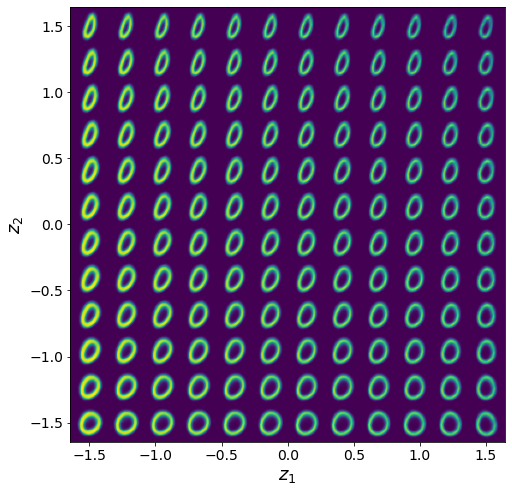

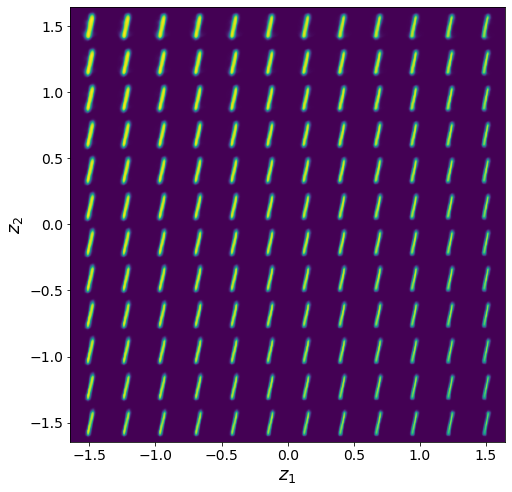

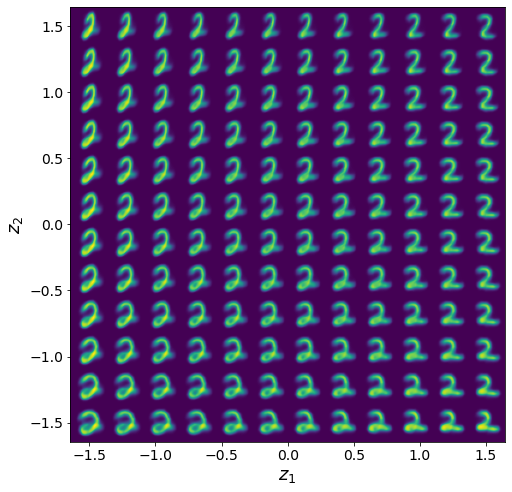

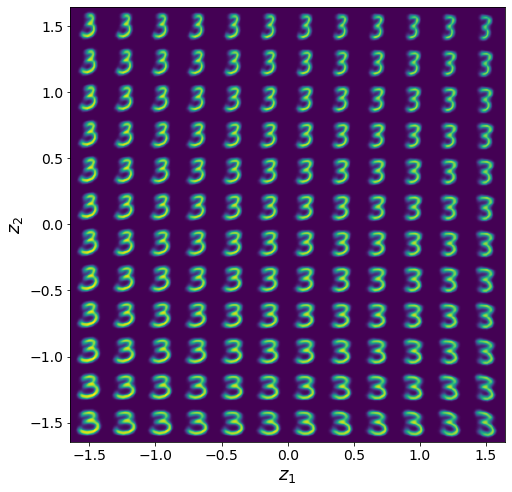

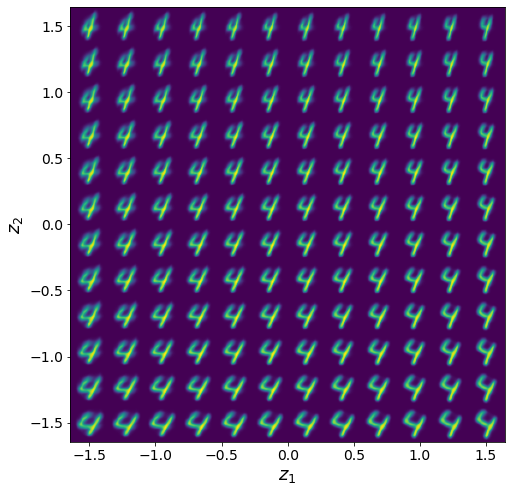

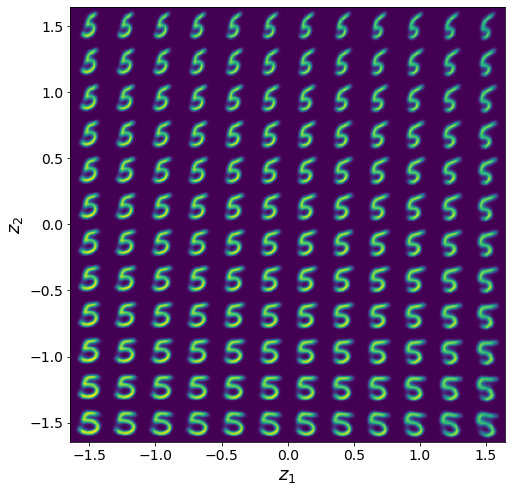

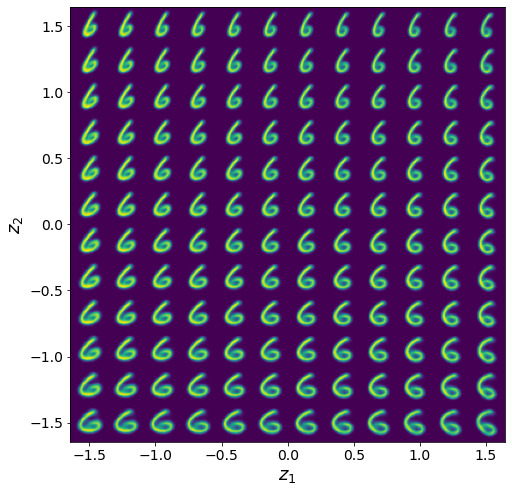

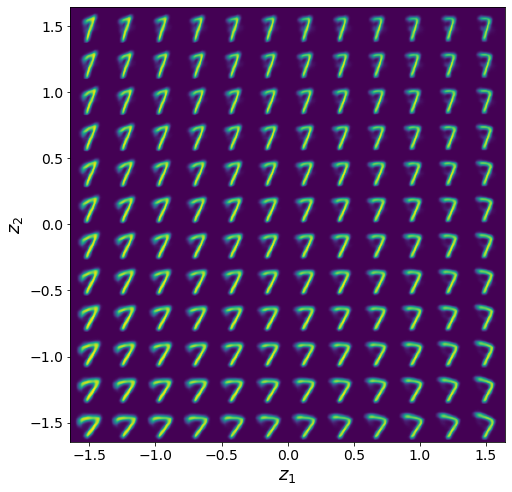

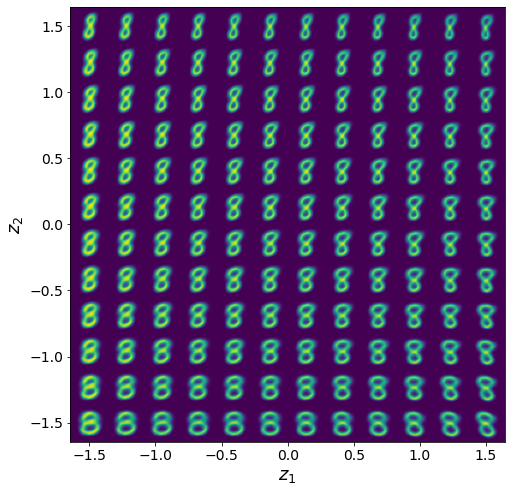

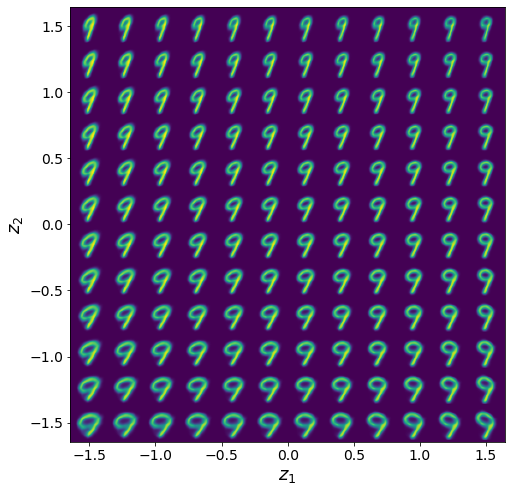

In [16]:
for i in range(10):
    crvae.manifold2d(d=12, label=i, cmap="viridis")

In this case, our latent reconstructions clearly show that within each latent space, the digits are oriented in the same direction, and latent variables now encode very subtle details of the handwriting styles.

Encode all the data and view the encoded values as a scatter plot:

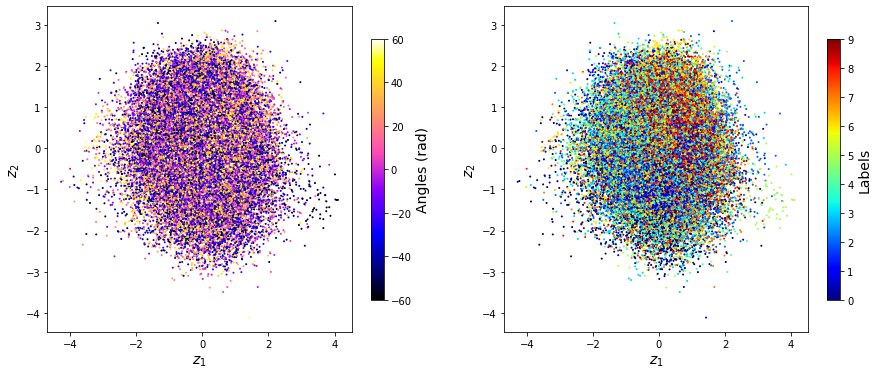

In [17]:
z_mean, z_sd = crvae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,2], z_mean[:,1], c=angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,2], z_mean[:,1], c=labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10)